# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [138]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf, asc, last,countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType, DateType
from pyspark.sql.window import Window
from pyspark.ml.feature import CountVectorizer,Normalizer,  StandardScaler, StringIndexer, VectorAssembler,MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator, Evaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re

import datetime
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Capstone") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_data = 'mini_sparkify_event_data.json'

In [5]:
#load data to a data frame 
df=spark.read.json(sparkify_data)

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [74]:
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
df.count() #286500

286500

In [7]:
user_log= df.dropna(how= "any", subset = ["userId", "sessionId"])
#there is no null records as count of rows did not change 

In [8]:
user_log.count()

286500

In [9]:
user_log.select("userId").dropDuplicates().sort("userId").show()
# there are no missing values in the userID or session columns.
#But there are userID values that are empty strings.

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [10]:
user_log = user_log.filter(user_log["userId"] != "")
#filter records with empty string 

In [13]:
user_log.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [15]:
user_log.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [16]:
user_log.select(["userId", "page", "level"]).where(user_log.page =='Cancellation Confirmation').collect()

[Row(userId='18', page='Cancellation Confirmation', level='paid'),
 Row(userId='32', page='Cancellation Confirmation', level='paid'),
 Row(userId='125', page='Cancellation Confirmation', level='free'),
 Row(userId='105', page='Cancellation Confirmation', level='paid'),
 Row(userId='17', page='Cancellation Confirmation', level='paid'),
 Row(userId='143', page='Cancellation Confirmation', level='free'),
 Row(userId='101', page='Cancellation Confirmation', level='paid'),
 Row(userId='129', page='Cancellation Confirmation', level='paid'),
 Row(userId='121', page='Cancellation Confirmation', level='paid'),
 Row(userId='51', page='Cancellation Confirmation', level='paid'),
 Row(userId='87', page='Cancellation Confirmation', level='paid'),
 Row(userId='122', page='Cancellation Confirmation', level='paid'),
 Row(userId='12', page='Cancellation Confirmation', level='paid'),
 Row(userId='58', page='Cancellation Confirmation', level='paid'),
 Row(userId='73', page='Cancellation Confirmation', lev

In [11]:
#lambda functiıon for labelling churn
cancelConfirm_event = udf(lambda x: 1 if  x=="Cancellation Confirmation"  else 0, IntegerType())

In [12]:
user_log = user_log.withColumn("churn",cancelConfirm_event("page"))

In [19]:
user_log.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0)]

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [14]:
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))

In [15]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [16]:
user_log = user_log.withColumn("date", get_timestamp(user_log.ts))

In [17]:
user_log = user_log.withColumn("registrationDate", get_timestamp(user_log.registration))

In [18]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, hour='0', date='2018-10-01', registrationDate='2018-09-28')

In [26]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [27]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [28]:
churn_in_hour = user_log.filter(user_log.churn == "1").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [29]:
churn_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|    3|
|   1|    1|
|   2|    1|
|   3|    2|
|   4|    2|
|   5|    1|
|   7|    6|
|   8|    1|
|  10|    1|
|  11|    2|
|  12|    2|
|  13|    1|
|  14|    1|
|  15|    4|
|  16|    4|
|  17|    2|
|  18|    3|
|  19|    5|
|  20|    3|
|  21|    3|
+----+-----+
only showing top 20 rows



In [30]:
churn_in_hour_pd = churn_in_hour.toPandas()
churn_in_hour_pd.hour = pd.to_numeric(churn_in_hour_pd.hour)

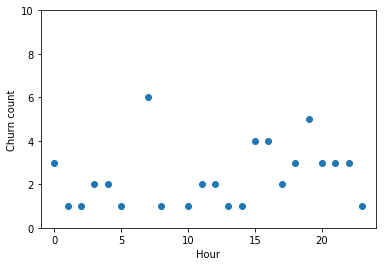

In [31]:
plt.scatter(churn_in_hour_pd["hour"], churn_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 10)
plt.xlabel("Hour")
plt.ylabel("Churn count");

In [32]:
#count of levels which churned users had
churn_level = user_log.filter(user_log.churn == "1").groupby(user_log.level).count()

churn_level.show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [33]:
churn_level_pd = churn_level.toPandas()

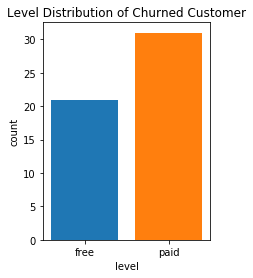

In [34]:
# Plot
plt.rcParams['figure.figsize'] = (3,4)
sns.barplot(x='level', y = 'count', data = churn_level_pd, saturation = 1);
plt.title('Level Distribution of Churned Customer');

In [35]:
# for more investigation on data
user_log.createOrReplaceTempView("user_log_table")

In [36]:
spark.sql("SELECT count(distinct userID) FROM user_log_table where churn='1'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



In [37]:
spark.sql("SELECT count(distinct userID) FROM user_log_table").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   225|
+----------------------+



In [19]:
user_window = Window.partitionBy('userID').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [20]:
user_log = user_log.withColumn("churned", Fmax('churn').over(Window.partitionBy("userId")))

In [21]:
user_log = user_log.withColumn("lastlevel", last(col('level')).over(user_window))

In [41]:
user_log.filter(user_log["level"]!= user_log["lastlevel"]).show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+----+----------+----------------+-------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|hour|      date|registrationDate|churned|lastlevel|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+----+----------+----------------+-------+---------+
|  null|Logged In|     Lily|     F|           69| Barnett|  null| paid|Washington-Arling...|   PUT|Submit Downgrade|1537053412000|      812|null|   307|1539467798000|"Mozilla/5.0 (Mac...|    35|    0|  21|2018-10-13|      2018-09-15|      0|   

In [42]:
user_log.filter(user_log["churned"] == 1).select(["userId", "gender", "level","lastlevel", "page", "song", "status", "registrationDate", "date", "churned", "churn"]).show(60)

+------+------+-----+---------+--------------------+--------------------+------+----------------+----------+-------+-----+
|userId|gender|level|lastlevel|                page|                song|status|registrationDate|      date|churned|churn|
+------+------+-----+---------+--------------------+--------------------+------+----------------+----------+-------+-----+
|   125|     M| free|     free|              Cancel|                null|   307|      2018-08-01|2018-10-12|      1|    0|
|   125|     M| free|     free|Cancellation Conf...|                null|   200|      2018-08-01|2018-10-12|      1|    1|
|   125|     M| free|     free|         Roll Advert|                null|   200|      2018-08-01|2018-10-12|      1|    0|
|   125|     M| free|     free|            NextSong|                Kota|   200|      2018-08-01|2018-10-12|      1|    0|
|   125|     M| free|     free|            NextSong|     They're Red Hot|   200|      2018-08-01|2018-10-12|      1|    0|
|   125|     M| 

In [43]:
churned_users=user_log.filter(user_log["churned"] == 1).select(["userId", "gender", "level", "page", "song", "status", "registrationDate", "date", "churned", "churn"])

In [44]:
churned_users.head()

Row(userId='125', gender='M', level='free', page='NextSong', song='paranoid android', status=200, registrationDate='2018-08-01', date='2018-10-12', churned=1, churn=0)

In [45]:
stayed_users=user_log.filter(user_log["churned"] == 0).select(["userId", "gender", "level", "page", "song", "status", "registrationDate", "date", "churned", "churn"])

In [46]:
stayed_users.createOrReplaceTempView("stayed_users")

In [47]:
churned_users.createOrReplaceTempView("churned_users")

In [48]:
spark.sql("SELECT page, count(*) as count FROM churned_users group by page order by count desc").show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|            NextSong|36394|
|           Thumbs Up| 1859|
|                Home| 1672|
|     Add to Playlist| 1038|
|         Roll Advert|  967|
|          Add Friend|  636|
|              Logout|  553|
|         Thumbs Down|  496|
|           Downgrade|  337|
|            Settings|  270|
|                Help|  239|
|             Upgrade|  112|
|       Save Settings|   58|
|               About|   56|
|              Cancel|   52|
|Cancellation Conf...|   52|
|               Error|   32|
|      Submit Upgrade|   32|
|    Submit Downgrade|    9|
+--------------------+-----+



In [49]:
spark.sql("SELECT  page, count(*) as count FROM stayed_users group by page order by count desc").show()

+----------------+------+
|            page| count|
+----------------+------+
|        NextSong|191714|
|       Thumbs Up| 10692|
|            Home|  8410|
| Add to Playlist|  5488|
|      Add Friend|  3641|
|     Roll Advert|  2966|
|          Logout|  2673|
|     Thumbs Down|  2050|
|       Downgrade|  1718|
|        Settings|  1244|
|            Help|  1215|
|           About|   439|
|         Upgrade|   387|
|   Save Settings|   252|
|           Error|   220|
|  Submit Upgrade|   127|
|Submit Downgrade|    54|
+----------------+------+



In [22]:
#creating features for models

user_artist = user_log.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")

user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



In [23]:
#creating features for models

user_song = user_log.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")

user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [24]:
#creating features for models

user_error = user_log.filter(user_log.status != '200').groupby("userId").agg({"status": "count"}).withColumnRenamed("count(status)", "error_count")

user_error.show(5)

+------+-----------+
|userId|error_count|
+------+-----------+
|100010|         31|
|200002|         37|
|   125|          1|
|    51|        176|
|   124|        357|
+------+-----------+
only showing top 5 rows



In [25]:
#creating features for models

user_error_page = user_log.filter(user_log.page == 'Error').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "error_page_count")

user_error_page.show(5)

+------+----------------+
|userId|error_page_count|
+------+----------------+
|   124|               6|
|    51|               1|
|     7|               1|
|    15|               2|
|    54|               1|
+------+----------------+
only showing top 5 rows



In [26]:
#creating features for models

user_playlist = user_log.filter(user_log.page== 'Add to Playlist').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "playlist_count")

user_playlist.show(5)

+------+--------------+
|userId|playlist_count|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
+------+--------------+
only showing top 5 rows



In [56]:
#user_downgrade= user_log.filter(user_log.page== 'Submit Downgrade').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "downgrade_count")

#user_downgrade.show(20)

In [27]:
#creating features for models

user_addFriend= user_log.filter(user_log.page== 'Add Friend').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "addFriend_count")

user_addFriend.show(5)

+------+---------------+
|userId|addFriend_count|
+------+---------------+
|100010|              4|
|200002|              4|
|    51|             28|
|   124|             74|
|     7|              1|
+------+---------------+
only showing top 5 rows



In [28]:
#creating features for models

user_upgrade= user_log.filter(user_log.page== 'Submit Upgrade').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "upgrade_count")

user_upgrade.show(5)

+------+-------------+
|userId|upgrade_count|
+------+-------------+
|200002|            1|
|    54|            1|
|   155|            1|
|   132|            1|
|   101|            1|
+------+-------------+
only showing top 5 rows



In [29]:
#creating features for models

user_visitHome= user_log.filter(user_log.page== 'Home').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "visitHome_count")

user_visitHome.show(5)

+------+---------------+
|userId|visitHome_count|
+------+---------------+
|100010|             11|
|200002|             20|
|    51|             75|
|   124|            176|
|     7|             10|
+------+---------------+
only showing top 5 rows



In [30]:
#creating features for models

user_thumpsDown= user_log.filter(user_log.page== 'Thumbs Down').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "thumbsDown_count")

user_thumpsDown.show(5)

+------+----------------+
|userId|thumbsDown_count|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
+------+----------------+
only showing top 5 rows



In [31]:
#creating features for models

user_thumpsUp= user_log.filter(user_log.page== 'Thumbs Up').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "thumbsUp_count")

user_thumpsUp.show(5)

+------+--------------+
|userId|thumbsUp_count|
+------+--------------+
|100010|            17|
|200002|            21|
|    51|           100|
|   124|           171|
|     7|             7|
+------+--------------+
only showing top 5 rows



In [32]:
#creating features for models

user_rollAdvert= user_log.filter(user_log.page== 'Roll Advert').groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "rollAdvert_count")

user_rollAdvert.show(5)

+------+----------------+
|userId|rollAdvert_count|
+------+----------------+
|100010|              52|
|200002|               7|
|   125|               1|
|     7|              16|
|   124|               4|
+------+----------------+
only showing top 5 rows



In [33]:
#creating features for models

user_activeDays = user_log.select('userId', 'date').groupby('userId').agg(countDistinct('date')).withColumnRenamed('count(DISTINCT date)', 'dateCount')

user_activeDays.show(5)

+------+---------+
|userId|dateCount|
+------+---------+
|100010|        7|
|200002|        7|
|   125|        1|
|   124|       33|
|    51|       13|
+------+---------+
only showing top 5 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
#dealing with categorical variables
indexer = StringIndexer(inputCol="lastlevel", outputCol="levelTransformed")
user_log = indexer.fit(user_log).transform(user_log)

In [35]:
#dealing with categorical variables
indexer = StringIndexer(inputCol="gender", outputCol="genderTransformed")
user_log = indexer.fit(user_log).transform(user_log)

In [36]:
user_churned = user_log.groupby('userId').max("churned").withColumnRenamed("max(churned)", "label")

In [37]:
user_level=user_log.groupby('userId').max("levelTransformed").withColumnRenamed("max(levelTransformed)", "level")

In [129]:
user_rollAdvert.count()  #207

207

In [130]:
user_thumpsUp.count()  #220

220

In [131]:
user_thumpsDown.count() #203

203

In [132]:
user_visitHome.count() #223

223

In [133]:
user_upgrade.count() #131

131

In [134]:
user_downgrade.count() #49 #out

49

In [135]:
user_addFriend.count() #206

206

In [136]:
user_playlist.count()#215

215

In [137]:
user_error_page.count() #117

117

In [138]:
user_error.count() #223

223

In [147]:
user_level.head(5)

[Row(userId='100010', level=1.0),
 Row(userId='200002', level=1.0),
 Row(userId='125', level=1.0),
 Row(userId='124', level=0.0),
 Row(userId='51', level=0.0)]

In [38]:
user_gender=user_log.groupby('userId').max("genderTransformed").withColumnRenamed("max(genderTransformed)", "gender")

In [39]:
#creating feature data frame without loosing data wiht left join
feature=user_churned.join(user_rollAdvert, ['userId'],how='left') \
    .join(user_thumpsUp, ['userId'],how='left') \
    .join(user_thumpsDown, ['userId'],how='left') \
    .join(user_visitHome, ['userId'],how='left') \
    .join(user_upgrade, ['userId'],how='left') \
    .join(user_addFriend, ['userId'],how='left') \
    .join(user_playlist, ['userId'],how='left') \
    .join(user_error_page, ['userId'],how='left') \
    .join(user_error, ['userId'],how='left') \
    .join(user_song, ['userId'],how='left') \
    .join(user_artist, ['userId'],how='left') \
    .join(user_activeDays, ['userId'],how='left') \
    .join(user_level, ['userId'],how='left') \
    .join(user_gender, ['userId'],how='left')

In [40]:
feature.head()

Row(userId='100010', label=0, rollAdvert_count=52, thumbsUp_count=17, thumbsDown_count=5, visitHome_count=11, upgrade_count=None, addFriend_count=4, playlist_count=7, error_page_count=None, error_count=31, song_count=275, artist_count=275, dateCount=7, level=1.0, gender=0.0)

In [71]:
feature.count()

225

In [41]:
feature = feature.fillna(0)

In [42]:
feature=feature.drop('userId')

In [64]:
feature.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,225,0.2311111111111111,0.4224832108996327,0,1
rollAdvert_count,225,17.48,21.550207158434198,0,128
thumbsUp_count,225,55.782222222222224,65.47792460907043,0,437
thumbsDown_count,225,11.315555555555555,13.077481251105503,0,75
visitHome_count,225,44.80888888888889,47.29612177463004,0,355
upgrade_count,225,0.7066666666666667,0.7338742593737899,0,4
addFriend_count,225,19.00888888888889,20.581716728496275,0,143
playlist_count,225,29.004444444444445,32.716653931055426,0,240
error_page_count,225,1.12,1.4726070176973318,0,7


In [86]:
#after some descriptive observations of feature data frame, ı decided to drop artist_count as it same with song_count
feature=feature.drop('artist_count')

In [87]:
feature_pd = feature.toPandas()

In [88]:
feature_pd.head()

,label,rollAdvert_count,thumbsUp_count,thumbsDown_count,visitHome_count,upgrade_count,addFriend_count,playlist_count,error_page_count,error_count,song_count,dateCount,level,gender
0,0,52,17,5,11,0,4,7,0,31,275,7,1.0,0.0
1,0,7,21,6,20,1,4,8,0,37,387,7,1.0,1.0
2,1,1,0,0,0,0,0,0,0,1,8,1,1.0,1.0
3,0,4,171,41,176,0,74,118,6,357,4079,33,0.0,0.0
4,1,0,100,21,75,0,28,52,1,176,2111,13,0.0,1.0


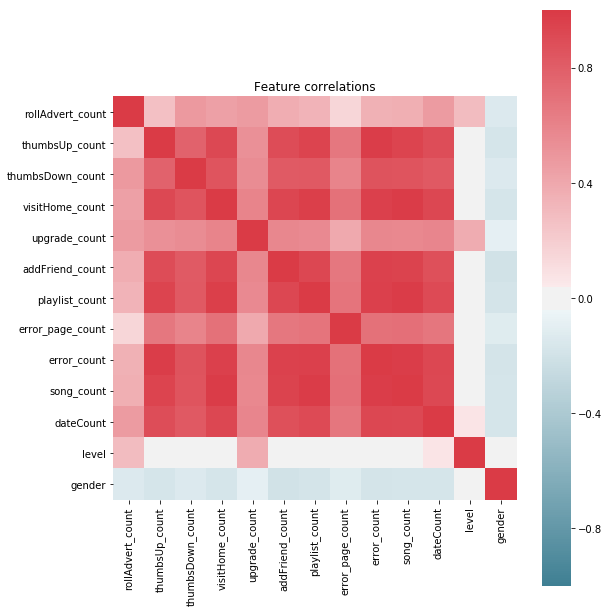

In [89]:
# Calculate correlations between numerical features
cormat = feature_pd[['rollAdvert_count','thumbsUp_count', 'thumbsDown_count', 'visitHome_count','upgrade_count','addFriend_count', 
'playlist_count', 'error_page_count', 'error_count', 'song_count', 'dateCount','level','gender']].corr()

# Plot correlations
plt.rcParams['figure.figsize'] = (10,10)
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.heatmap(cormat, cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, vmin = -1, vmax = 1);
plt.title('Feature correlations');
plt.savefig('correlations.png')

In [90]:
# Define colors
colors = ["windows blue", "faded orange"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]

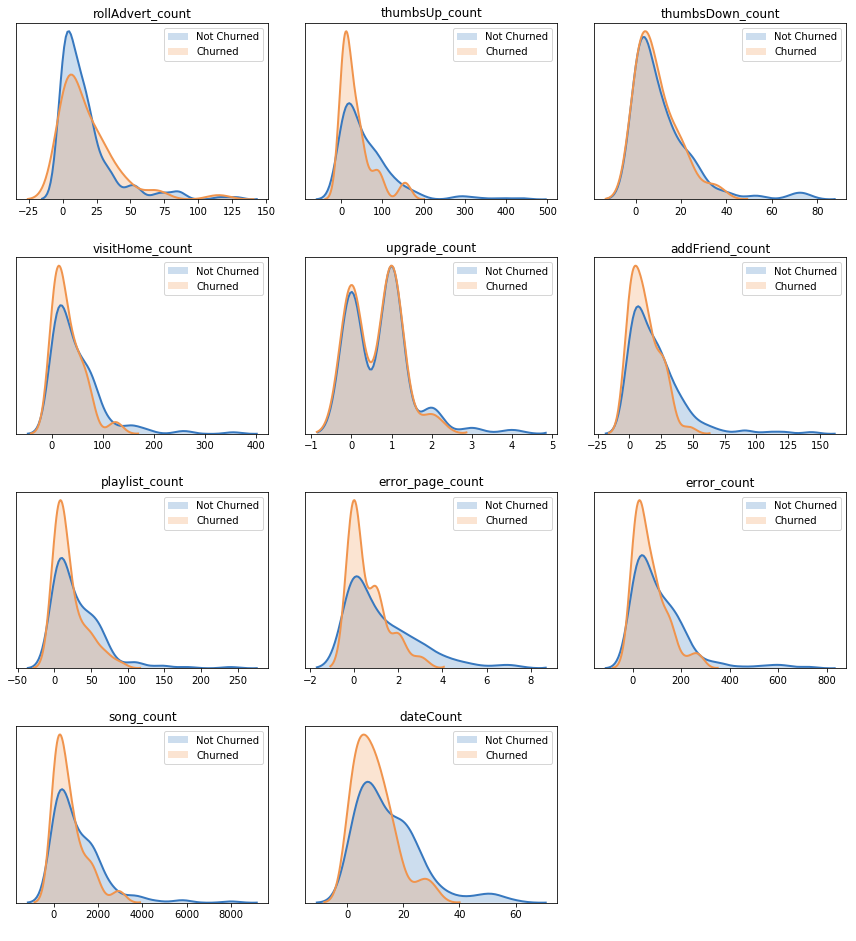

In [102]:
# Plotting the relationship between each numerical feature

col = ['rollAdvert_count','thumbsUp_count', 'thumbsDown_count', 'visitHome_count','upgrade_count','addFriend_count', 
'playlist_count', 'error_page_count', 'error_count', 'song_count','dateCount']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(col)):
    plt.subplot(5,3,i+1)
    plt.tight_layout();
    sns.distplot(feature_pd[feature_pd['label'] == 0][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color1);
    sns.distplot(feature_pd[feature_pd['label'] == 1][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color2);
    plt.legend(['Not Churned','Churned']);
    plt.title(col[i]);
    plt.xlabel(" ");
    plt.yticks([]);
    plt.savefig('exploratory.png')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [93]:
feature_names = ['rollAdvert_count','thumbsUp_count', 'thumbsDown_count', 'visitHome_count','upgrade_count', 'addFriend_count', 
'playlist_count', 'error_page_count', 'error_count', 'song_count','dateCount','level','gender']

def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_names, outputCol="features_vec")
    scalar = MinMaxScaler(inputCol="features_vec", outputCol="features")
    pipeline = Pipeline(stages=[assembler, scalar, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    return model

In [94]:
train, test = feature.randomSplit([0.8, 0.2], seed = 9) 

## Logistic Regression

In [95]:
# Create a logistic regression object
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [96]:
# Parameter combinations
paramGrid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10]) \
.addGrid(lr.regParam, [0.0]) \
.addGrid(lr.elasticNetParam, [0.0]) \
.build()

In [97]:
#building model
model = build_model(lr, paramGrid_lr)

In [98]:
%%time
model_lr = model.fit(train)

CPU times: user 4.93 s, sys: 1.55 s, total: 6.48 s
Wall time: 12min 54s


In [99]:
pred = model_lr.transform(test)

In [100]:
pred.head()

Row(label=0, rollAdvert_count=11, thumbsUp_count=303, thumbsDown_count=28, visitHome_count=151, upgrade_count=0, addFriend_count=63, playlist_count=113, error_page_count=5, error_count=443, song_count=3632, dateCount=50, level=0.0, gender=0.0, features_vec=DenseVector([11.0, 303.0, 28.0, 151.0, 0.0, 63.0, 113.0, 5.0, 443.0, 3632.0, 50.0, 0.0, 0.0]), features=DenseVector([0.0859, 0.6934, 0.3733, 0.4254, 0.0, 0.4406, 0.4708, 0.7143, 0.6127, 0.4537, 0.8448, 0.0, 0.0]), rawPrediction=DenseVector([8.6895, -8.6895]), probability=DenseVector([0.9998, 0.0002]), prediction=0.0)

In [101]:
#create evaluator to get F1 score and accuracy metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
print("f1: {} , accuracy: {}".format(f1_score, accuracy))

f1: 0.6466837169650469 , accuracy: 0.717391304347826


## Random Forest Classifier

In [103]:
# Create a random forest classifier object
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [104]:
# Parameter combinations
paramGrid_rf = ParamGridBuilder() \
.addGrid(rf.maxDepth, [4]) \
.addGrid(rf.numTrees, [40]) \
.build()

In [105]:
model = build_model(rf, paramGrid_rf)

In [106]:
%%time
rf_model = model.fit(train)

CPU times: user 4.93 s, sys: 1.41 s, total: 6.34 s
Wall time: 15min 16s


In [107]:
pred_rf = rf_model.transform(test)

In [108]:
#create evaluator to get F1 score and accuracy metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_rf, {evaluator.metricName: "accuracy"})
print("f1: {} , accuracy: {}".format(f1_score, accuracy))

f1: 0.6187841144362883 , accuracy: 0.717391304347826


In [129]:
# Display feature importances
importances = rf_model.bestModel.stages[2].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = feature_names
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
10,dateCount,0.135134
6,playlist_count,0.135075
2,thumbsDown_count,0.134857
0,rollAdvert_count,0.124970
9,song_count,0.086555
3,visitHome_count,0.082463
8,error_count,0.081788
5,addFriend_count,0.081522
1,thumbsUp_count,0.076494
7,error_page_count,0.032399


## Gradient Boosted Tree Classifier

In [109]:
# Create a gradient boosted tree classifier object
gbt = GBTClassifier(featuresCol="features", labelCol="label")

In [110]:
# Parameter combinations
paramGrid_gbt = ParamGridBuilder() \
.addGrid(gbt.maxDepth, [4]) \
.addGrid(gbt.maxIter, [20]) \
.build()

In [111]:
#building model
model = build_model(gbt, paramGrid_gbt)

In [112]:
%%time
gbt_model = model.fit(train)

CPU times: user 22.9 s, sys: 7.37 s, total: 30.3 s
Wall time: 41min 29s


In [113]:
pred_gbt =gbt_model.transform(test)

In [114]:
#create evaluator to get F1 score and accuracy metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(pred_gbt, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_gbt, {evaluator.metricName: "accuracy"})
print("f1: {} , accuracy: {}".format(f1_score, accuracy))

f1: 0.616783172941287 , accuracy: 0.6739130434782609


In [132]:
# Display feature importances
importances = gbt_model.bestModel.stages[2].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = feature_names
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
2,thumbsDown_count,0.148859
6,playlist_count,0.144906
0,rollAdvert_count,0.141014
1,thumbsUp_count,0.116545
10,dateCount,0.106025
5,addFriend_count,0.095641
9,song_count,0.060494
3,visitHome_count,0.059413
8,error_count,0.045413
12,gender,0.036894


## Decision Tree Classifier

In [144]:
# Create decision tree classifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

In [153]:
# Parameter combinations
paramGrid_dt = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [ 4])
             .addGrid(dt.maxBins, [20])
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .build())

In [154]:
#building model
model_dt = build_model(dt, paramGrid_dt)

In [155]:
%%time
dt_model = model_dt.fit(train)

CPU times: user 6.95 s, sys: 2.22 s, total: 9.17 s
Wall time: 15min 34s


In [156]:
pred_dt =dt_model.transform(test)

In [157]:
#create evaluator to get F1 score and accuracy metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(pred_dt, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_dt, {evaluator.metricName: "accuracy"})
print("f1: {} , accuracy: {}".format(f1_score, accuracy))

f1: 0.6618993135011442 , accuracy: 0.7391304347826086


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.